In [1]:
from transformers import LlamaForCausalLM
import torch
import numpy as np
import os
import gc
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import json
import plotly.graph_objects as go
from tqdm import tqdm
import numpy as np
from scipy.linalg import svd
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from analysis_utils import custom_svd

import warnings

# This will suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(2024)

In [2]:
def load_llama():
    llama = LlamaForCausalLM.from_pretrained(
        "meta-llama/Llama-2-7b-hf",
        device_map="cuda",
        torch_dtype=torch.bfloat16,
        output_attentions=True,
    )
    llama.eval()
    return llama


# extract IH list
def extract_IH_list(filter_later_layers=True):
    lines = open("simple_visz/induction_head_scores.txt").readlines()
    IH_list = []
    for line in lines[1:]:
        layerhead = line.split(":")[0]
        head = layerhead.split("Head")[1]
        layer = layerhead.split("Head")[0].split("Layer")[1]
        if int(layer) < 16 or (not filter_later_layers):
            IH_list.append([int(layer), int(head)])

    return IH_list


def compute_subspace_V(W_all, L, H, d):
    d_model = 4096
    W_qk = W_all[L, H, 0] @ W_all[L, H, 1].T
    W_qk = W_qk.numpy(force=True)
    U, S, Vt = custom_svd(W_qk.reshape(-1, d_model))

    return Vt[:d, :].T


def subspace_similarity(V1, V2):
    _, s, _ = custom_svd(np.dot(V1.T, V2))
    return np.sum(s)

In [3]:
W_all = torch.load("W_all.pt")  # torch.float32
IH_list = extract_IH_list(filter_later_layers=False)[:30]

# Compute the subspace representations
d = 100  # Dimension of the subspace
subspaces = []
for L, H in tqdm(IH_list):
    subspaces.append(compute_subspace_V(W_all, L, H, d))

100%|██████████| 30/30 [02:30<00:00,  5.02s/it]


In [4]:
# Compute the similarity matrix
n = len(subspaces)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        similarity = subspace_similarity(subspaces[i], subspaces[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

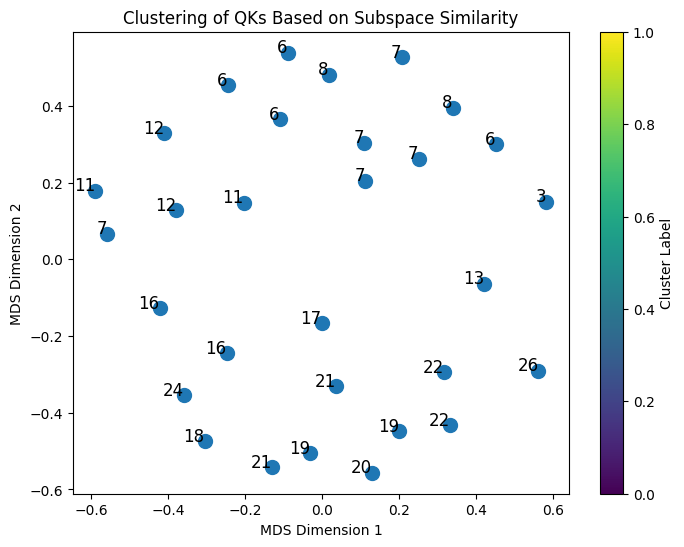

In [29]:
# Apply clustering
# num_clusters = 2  # Number of clusters
# kmeans = KMeans(n_clusters=num_clusters, random_state=0)
# labels = kmeans.fit_predict(similarity_matrix)

# Compute the MDS embedding
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

similarity_matrix_normalized = similarity_matrix / 100
embedding = mds.fit_transform(
    1 - similarity_matrix_normalized
)  # Use 1 - similarity_matrix to convert to dissimilarity

# Plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap="viridis", s=100)
for i, (L, H) in enumerate(IH_list):
    plt.annotate(L, (embedding[i, 0], embedding[i, 1]), fontsize=12, ha="right")

plt.title("Clustering of QKs Based on Subspace Similarity")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.colorbar(scatter, label="Cluster Label")
plt.show()

Text(0.5, 1.0, 'Similarity matrix, ordered by layer index of QK')

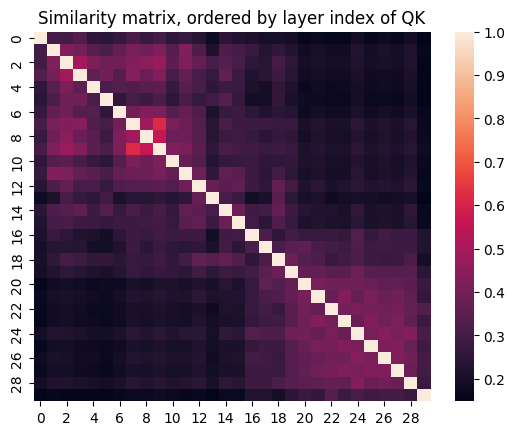

In [28]:
order = np.argsort([L for L, _ in IH_list]).tolist()
sns.heatmap(similarity_matrix_normalized[order][:, order])
plt.title("Similarity matrix, ordered by layer index of QK")